# Dark matter halo matter-concentration relations

This notebook will demonstrate the available matter-concentration relations implemented in 'halox' as well as the quantities that must be passed for each relation.

In [1]:
import jax
import jax.numpy as jnp
import halox
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

jax.config.update("jax_enable_x64", True)

/Users/lamoreau/halox/.venv/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


## Implemented Relations

The implemented relations so far include those from (Duffy et al. 2008, Klypin et al. 2011, Prada et al. 2012, and Child et al. 2016), with two different cases of Child18 for relaxed and unrelaxed halos, the relations are detailed mathematically below

#### duffy08
$c_{200c}(M,z) = A \left( \frac{M}{M_0} \right)^{B} (1+z)^{C}$

#### prada12
$\nu(M,z) = \frac{\delta_{\rm sc}}{\sigma(M,z)}\,\,\,\,\,\,\,\,x = \left( \frac{\Omega_{\Lambda}}{\Omega_m} \right)^{1/3} a$

$c_{\min}(x) = 3.681 + (5.033 - 3.681)
\left[ \frac{1}{\pi} \arctan\left( 6.948(x - 0.424) \right) + \frac{1}{2} \right]$

$\sigma_{\min}(x) = 1.047 + (1.646 - 1.047)
\left[ \frac{1}{\pi} \arctan\left( 7.386(x - 0.526) \right) + \frac{1}{2} \right]$

$B_0(x) = \frac{c_{\min}(x)}{c_{\min}(1.393)}\,\,\,\,\,\,\,\,B_1(x) = \frac{\sigma_{\min}(x)}{\sigma_{\min}(1.393)}\,\,\,\,\,\,\,\,\sigma' = B_1 \, \sigma(M,z)$

$c_{200c}(M,z) =
B_0 \,
2.881
\left[ \left( \frac{\sigma'}{1.257} \right)^{1.022} + 1 \right]
\exp\left( \frac{0.060}{\sigma'^2} \right)$

#### klypin11
At $z = 0:\,\,\,c_{\rm vir}(M) = 9.6
\left( \frac{M}{10^{12}\, h^{-1} M_\odot} \right)^{-0.075}$

#### child18 (two cases differ solely by parameter value)
$c_{200c}(M,z) =
c_0 + A
\left[
x^{m_{\rm ex}} (1+x)^{-m_{\rm ex}} - 1
\right]$

where 

$x = \frac{M}{b \, M_*}$

with $M_*$ being the redshift dependent non-linear mass scale. See section 4 with equation 13 for more details.

In [3]:
from halox.cm import (
    duffy08,
    prada12,
    klypin11,
    child18all,
    child18relaxed,
)

## Setting up the cosmology
As per usual with halox, our first step is setting up the cosmology that we will be using. It is important to note that certain masses, redshifts, and cosmologies may not necessarily be compatible with all the relations below, checking the docstring with help() is the best way to check the compatability.

In [4]:
p18 = halox.cosmology.Planck18()

mray = jnp.logspace(11, 15, 20)
zray = jnp.linspace(0, 2.25, 9)

print(help(prada12))

Help on class prada12 in module halox.cm:

class prada12(builtins.object)
 |  prada12(cosmo: jax_cosmo.core.Cosmology)
 |  
 |  prada12 mass-concentration relation using M200c.
 |  
 |  (http://adsabs.harvard.edu/abs/2012MNRAS.423.3018P)
 |  
 |  Calibrated cosmologies
 |  ----------------------
 |  Any (cosmology-dependent through sigma(M, z))
 |  
 |  Valid range
 |  -----------
 |  M : Any
 |  z : Any
 |  
 |  Parameters
 |  ----------
 |  cosmo : jc.Cosmology
 |      Cosmology used to compute sigma(M, z)
 |  
 |  M : ArrayLike
 |      M200c (h^-1 Solar Masses)
 |  
 |  z : ArrayLike
 |      Redshift
 |  
 |  Returns
 |  -------
 |  c : ArrayLike
 |      Concentration (c200c)
 |  
 |  Notes
 |  -----
 |  This model predicts concentration as a function of peak height
 |  through sigma(M, z), and captures an upturn in concentration at
 |  high masses.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, M: Union[jax.Array, numpy.ndarray, numpy.bool, numpy.number, bool, int, float, c

## Loading relations and vectorization of concentration computation

To load a relation, call its class, initialize it with a cosmology if necessary, and pass it masses and redshifts.

As with the other parts of halox, you are able to compute concentrations in parallel for multiple redshifts using jax.vmap as shown below. Klypin has no redshift dependence encoded and is therefore not vectorized in z.

In [5]:
def vectorize_model(model, mray, zray):
    return jax.vmap(lambda z: model(mray, z))(zray)


cduffy = vectorize_model(duffy08(), mray, zray)
cprada = vectorize_model(prada12(p18), mray, zray)
ccall = vectorize_model(child18all(p18), mray, zray)
ccrel = vectorize_model(child18relaxed(p18), mray, zray)

x = p18.Omega_m - 1
# Below: Brian and Norman virial overdensity calculation
deltaBN = 18 * jnp.pi**2 + 82 * x - 39 * x**2
mklyp, rklyp, cklyp = halox.halo.nfw.delta_delta(
    mray,
    cduffy[0],
    z=zray[0] * jnp.ones(len(mray)),
    cosmo=p18,
    delta_old=200,
    delta_new=deltaBN,
)
cklypin = klypin11()(M=mklyp)

## Plotting relations across different redshift

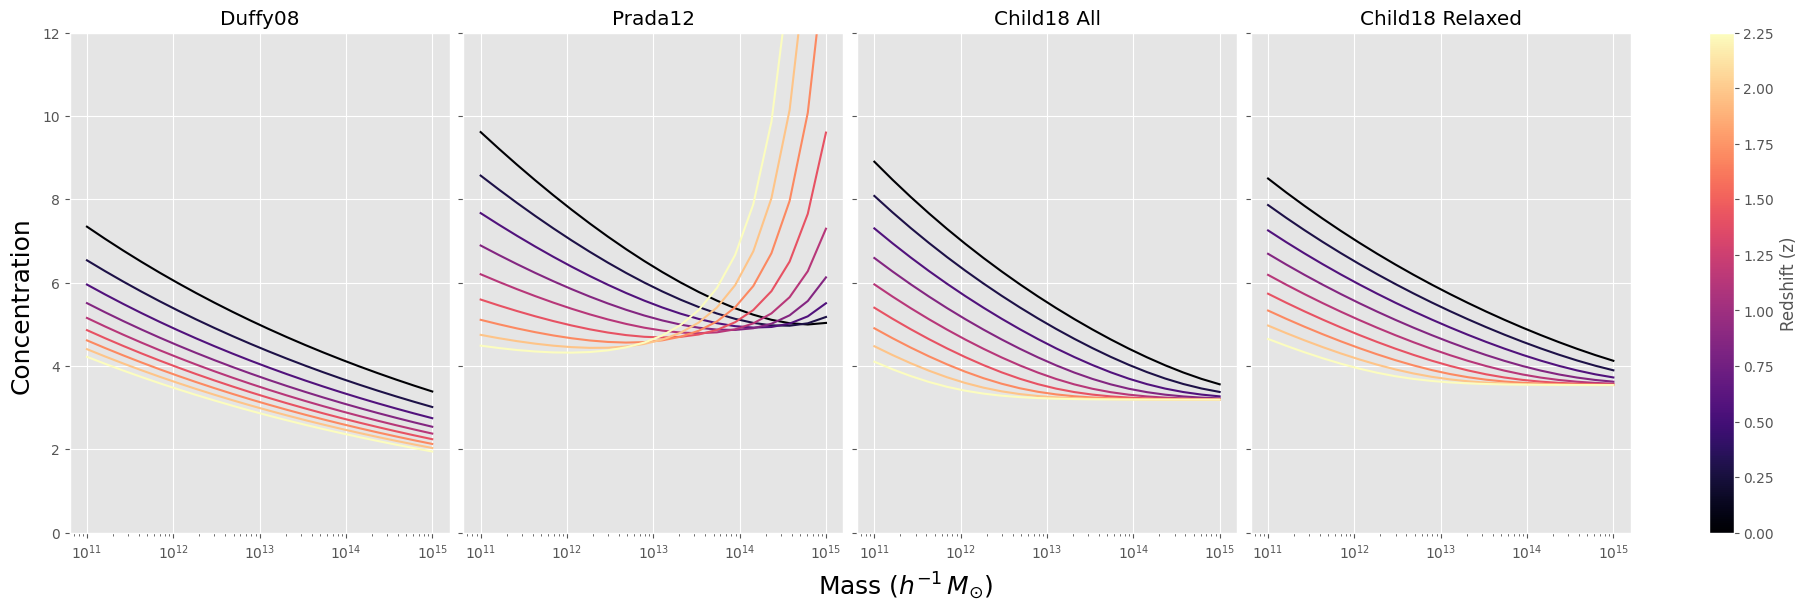

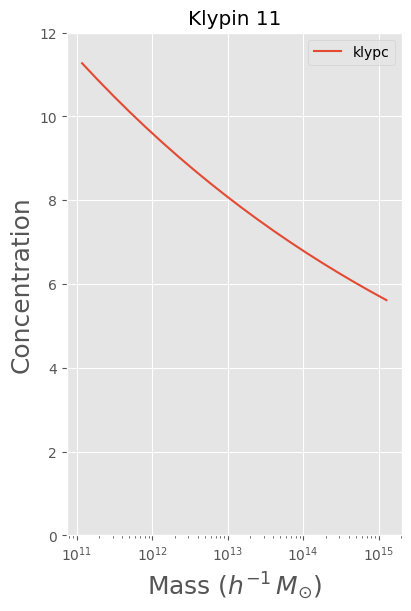

In [6]:
plt.style.use("ggplot")

models = [
    ("Duffy08", cduffy),
    ("Prada12", cprada),
    ("Child18 All", ccall),
    ("Child18 Relaxed", ccrel),
]

fig, axes = plt.subplots(
    1, 4, figsize=(18, 6), sharex=True, sharey=True, constrained_layout=True
)

norm = mcolors.Normalize(vmin=zray.min(), vmax=zray.max())
cmap = cm.magma

for ax, (name, cvals) in zip(axes, models):
    for i, z in enumerate(zray):
        color = cmap(norm(z))
        ax.plot(mray, cvals[i], color=color)

    ax.set_xscale("log")
    ax.set_title(name)
    ax.set_ylim(0, 12)

fig.supylabel("Concentration", fontsize=18)
fig.supxlabel(r"Mass $(h^{-1}\,M_{\odot})$", fontsize=18)
# Shared colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes.ravel().tolist())
cbar.set_label("Redshift (z)")

plt.show()

plt.figure(figsize=(4, 6), constrained_layout=True)
plt.plot(mklyp, cklypin, label="klypc")
# plt.plot(mklyp, cklyp, label = "duffyconvc")
plt.ylim(0, 12)
plt.xscale("log")
plt.title("Klypin 11")
plt.ylabel("Concentration", fontsize=18)
plt.xlabel(r"Mass $(h^{-1}\,M_{\odot})$", fontsize=18)

plt.legend()
plt.show()